# Reinforcement Learning
## Graded Assessment: RL Project



## Problem Definition

For this reinforcement learning project, the challenge involves developing an RL agent that can proficiently navigate the HighwayEnv, a minimalist simulation environment tailored for autonomous driving decision-making. The primary objective is to construct an RL agent capable of effectively managing the simulated traffic dynamics of HighwayEnv, and subsequently, to benchmark its performance against a pre-existing agent implemented via the [Stable Baselines3](https://github.com/DLR-RM/stable-baselines3) library.

### Environment Description
**HighwayEnv** simulates the complex scenario where autonomous vehicles are required to navigate traffic on a multi-lane highway. The overarching goal for these agents includes optimizing travel time, executing safe lane changes, maintaining appropriate speeds, and adhering to traffic regulations to avoid collisions.

### State Space (Observations)
The state space comprises:
- **Position and Velocity of the Agent Vehicle:** Longitudinal and lateral positions and velocities are critical for determining the agent's current and projected states.
- **Position and Velocity of Other Vehicles:** The relative positions and velocities of nearby vehicles are essential for spatial awareness and collision avoidance.
- **Road Geometry:** This includes the number of lanes and lane markings, which are crucial for proper lane adherence and navigation.

### Action Space
The agent can take several discrete actions:
- **Accelerate:** Increase the vehicle's speed.
- **Decelerate:** Reduce the vehicle's speed.
- **Change Lane to the Left/Right:** Shift to an adjacent left or right lane if it is safe and possible.
- **Maintain Current State:** Continue with the present speed and lane.

### Transition Dynamics
The dynamics of this environment are governed by both the physical laws of vehicle motion and the programmed behavior of other simulated vehicles, which follow basic traffic rules and patterns of lane adherence.

### Reward Function
The reward system is designed to promote safety, efficiency, comfort, and lane adherence:
- **Safety:** Imposes penalties for near-misses and collisions.
- **Efficiency:** Rewards are given for maintaining optimal speeds and minimizing travel time to goals.
- **Comfort:** Discourages excessive and abrupt vehicular maneuvers.
- **Lane Adherence:** Encourages maintaining lane discipline unless overtaking or avoiding an obstacle.

### Hypothesis
The hypothesis to be tested is whether a custom-implemented Deep Q-Network (DQN) can outperform an established RL agent from the Stable Baselines3 library in terms of cumulative rewards. This will be measured through the agent’s ability to adapt to varying traffic densities and complexities, ensuring both efficient and safe navigation.

### Objectives for the DQN Implementation
The project aims to implement a DQN that learns an optimal policy based on the defined state and action spaces, adhering to the specified transition dynamics and reward structure. The key objectives for the DQN agent include:
- Efficiently navigating through traffic without predefined rules for specific situations.
- Developing a balanced driving policy that optimizes speed, safety, and comfort.
- Demonstrating superior adaptability and performance in diverse traffic scenarios when compared to the existing solution.

This structured approach lays the groundwork for developing and evaluating the reinforcement learning model, focusing on fostering an autonomous driving strategy that can effectively operate within the realistic confines of highway traffic conditions.

## Background

Reinforcement Learning (RL) has emerged as a powerful method for solving decision-making problems where an agent learns to act in an environment by performing actions and receiving feedback through rewards. In the context of autonomous driving, particularly in complex environments like those simulated by HighwayEnv, RL can be leveraged to enable vehicles to make intelligent decisions dynamically.

**Deep Q-Networks (DQN)**, introduced by Mnih et al. (2015), have been pivotal in applying RL to environments with high-dimensional state spaces, such as video games and, relevantly, driving simulations (Mnih et al., 2015). DQN integrates deep neural networks with Q-learning, where the network approximates the Q-value function. The Q-value function quantifies the expected utility of taking a given action in a particular state, followed by following a certain policy. **Strengths** of DQN include its ability to handle environments with large state and action spaces and its robustness in learning stable policies in complex scenarios. However, **weaknesses** include its sample inefficiency—often requiring numerous interactions with the environment, which can be computationally expensive—and its tendency to overestimate Q-values leading to suboptimal policy decisions.

**Proximal Policy Optimization (PPO)** and **Trust Region Policy Optimization (TRPO)** are policy gradient methods that optimize the policy directly. These methods are noted for their stability and efficiency, which come from limiting the steps in policy space to avoid destructive large updates (Schulman et al., 2015; 2017). For autonomous driving, the **strength** of these methods lies in their continuous action space handling, making them suitable for controlling the nuanced actions of a vehicle. The **weakness**, however, is that they can be sensitive to hyperparameter settings and require careful tuning to achieve the best performance.

In autonomous driving simulations like those provided by HighwayEnv, several studies have demonstrated the effectiveness of these methods. For example, RL has been used to successfully navigate complex traffic scenarios, demonstrating significant potential in achieving human-like driving capabilities (Dosovitskiy et al., 2017). These environments often simulate realistic traffic conditions and provide a benchmark for evaluating different RL methods, including DQN and PPO, in terms of their ability to learn safe and efficient driving policies.

Comparative studies, such as those by Liang et al. (2018), have shown that while DQN can effectively learn policy for discrete action spaces in driving simulations, methods like PPO tend to outperform in terms of achieving smoother control and handling continuous action spaces, which are critical in real-world driving scenarios.

In summary, reinforcement learning offers significant promise for developing intelligent autonomous driving systems capable of operating in complex, dynamic environments. Both value-based methods like DQN and policy-based methods like PPO have their merits and limitations, making them suitable for different aspects of the driving problem. Continuous advancements in RL methods and computational resources are likely to further enhance their applicability and performance in autonomous driving tasks.

## Method

### Setting Up the Highway Environment

The highway-env environment introduces an exciting domain focused on autonomous driving and decision-making in traffic scenarios. This environment is designed for experimenting with various aspects of vehicle behavior, such as lane following, overtaking, and navigating through intersections, making it rich in learning opportunities for reinforcement learning applications.

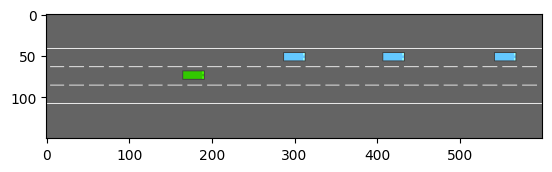

In [1]:
%matplotlib inline

import gymnasium as gym
from matplotlib import pyplot as plt

env = gym.make('highway-fast-v0', render_mode="rgb_array")
env.reset()

# To visualise a initial/idle state
action = env.unwrapped.action_type.actions_indexes["IDLE"]
obs, reward, done, truncated, info = env.step(action)

plt.imshow(env.render())
plt.show()

env.close()


### Exploring the Highway Environment

Exploring and understanding the environment by analysing the observation and action spaces, the dynamics of the environment, and the reward structure. Here’s how you can start exploring highway-env:

#### Understanding the Observation Space:

The observation space in highway-env can vary based on the configuration but typically includes the positions, velocities, and other attributes of nearby vehicles relative to the controlled vehicle. Understanding this space is crucial for designing your agent:

In [2]:
print("Observation space:", env.observation_space)

Observation space: Box(-inf, inf, (5, 5), float32)


#### Understanding the Action Space:
Actions in highway-env usually involve discrete decisions like changing lanes, accelerating, or braking:

In [3]:
print("Action space:", env.action_space)

Action space: Discrete(5)


#### Reward Structure Exploration

Understanding how rewards are assigned is crucial for designing your RL model. Perform actions and progress through the game to see what actions increase the score, how much reward is given for different achievements, and identify if there are any penalties.

In [4]:
# Example: Perform an action and observe the reward
env.reset()
for _ in range(50):
    _, reward, _, _, _ = env.step(env.action_space.sample())
    print("Reward received: ", reward)


Reward received:  0.7999999999999999
Reward received:  0.7999999999999999
Reward received:  0.8327113850086175
Reward received:  0.7175567607980314
Reward received:  0.7023121980100128
Reward received:  0.8160795220498324
Reward received:  0.8637845794187456
Reward received:  0.7505909305552
Reward received:  0.7013873830656888
Reward received:  0.7002958141970411
Reward received:  0.7333333333333334
Reward received:  0.849111821699985
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666666666665
Reward received:  0.06666666

#### Visualizing the Environment - Simulation:

You can visualize the environment in a Jupyter notebook or Python script to understand the dynamics visually. highway-env supports rendering directly to a Jupyter notebook using its render method.

In [5]:
import imageio
from IPython.display import Image, display

def generate_gif(frames):
    # Save the captured frames as a GIF
    gif_path = 'highway_simulation.gif'
    imageio.mimsave(gif_path, frames, fps=10)  # fps controls the speed of the animation

    # Display the GIF in the notebook
    display(Image(filename=gif_path))


Simple environment demonstration:

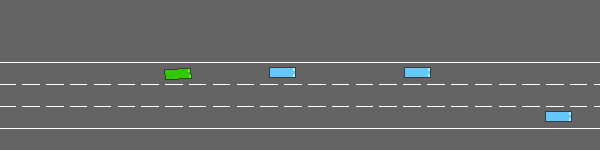

In [6]:
# reset environment
env.reset()

frames = []  # for storing the frames captured during the simulation

# Simulate the environment
for _ in range(50):
    action = env.action_space.sample()  # choose a random action
    obs, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
    done = terminated or truncated
    if done:
        env.reset()

# Close the environment to free resources
env.close()

generate_gif(frames)

#### Defining the objective:

The agent's object is straighforward: maximize average speed while minimizing collisions, with an additional goal of staying in the right lane as much as possible for extra reward. These objectives align well with the rewards settings described (collision_reward, high_speed_reward, and implicitly mentioning a right_lane_reward). This clarity will guide the design of your reinforcement learning model and the reward structure you implement.

### Heavy Traffic

In [7]:
import gymnasium as gym

env = gym.make("highway-fast-v0", render_mode='rgb_array')
env.reset()


(array([[ 1.        ,  0.7724457 ,  0.6666667 ,  0.3125    ,  0.        ],
        [ 1.        ,  0.10608794, -0.6666667 , -0.04544504,  0.        ],
        [ 1.        ,  0.23279905, -0.33333334, -0.01973059,  0.        ],
        [ 1.        ,  0.36426824, -0.33333334, -0.02661807,  0.        ],
        [ 1.        ,  0.49082628,  0.        , -0.03075124,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 3,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 1.0,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

## Baseline Performance with Stable Baselines3

Stable Baselines3 is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines.

### Model Training

Reinforcement Learning agents can be trained using libraries such as eleurent/rl-agents, openai/baselines or Stable Baselines3. In the next cell, a SB3 DQN is trained on highway-fast-v0 with its default kinematics observation and an MLP model. The hyperparameters come from the [documentation](https://highway-env.farama.org/quickstart/#training-an-agent) and, for a first training, the default values are used. Further tuning is performed next in this notebook.

Before the fine-tuning process, the chosen hyperparameters for the DQN model were set with a mix of default values and some tailored adjustments expected to work well for a range of problems:

- `net_arch=[256, 256]`: This specifies a neural network architecture with two hidden layers, each consisting of 256 neurons. This relatively large network architecture is chosen with the expectation that it can capture the complexity of the state space and learn effective policies.

- `learning_rate=5e-4`: The learning rate determines the step size at each iteration while moving toward a minimum of the loss function. A rate of 0.0005 is a common starting point that is not too large to overshoot minima nor too small to slow the convergence.

- `buffer_size=15000`: This is the size of the replay buffer. A larger buffer size allows the agent to learn from a broader set of experiences, potentially smoothing out the learning process and avoiding overfitting to recent experiences.

- `learning_starts=200`: This parameter determines how many steps of the model are run before the learning process begins. This warm-up period allows the replay buffer to fill with experiences, ensuring that learning does not begin with a poor understanding of the environment.

- `batch_size=32`: This sets the number of experiences to sample from the buffer to update the network at each learning step. A batch size of 32 is a standard choice that balances the variance and convergence rate.

- `gamma=0.8`: The discount factor, gamma, balances immediate and future rewards. A value of 0.8 suggests that future rewards are taken into consideration significantly, but with a preference for more immediate rewards.

- `train_freq=1`: This sets the frequency of training the network. Here, the network is trained at every step.

- `gradient_steps=1`: This is the number of gradient steps taken for each training step. Since this is set to 1, it means that a single optimization step is taken for each training step.

- `target_update_interval=50`: This parameter sets how often the target network is updated. The target network stabilizes training by providing a fixed snapshot of the policy for a period of time. An interval of 50 is a balance between stability and responsiveness to changes in the policy.

- `verbose=1`: This sets the verbosity level to output detailed logs during training.

- `tensorboard_log="highway_dqn_baseline/tensorboard_logs"`: This argument points to the directory where TensorBoard logs should be saved, enabling visualization of the training process.

These hyperparameters were chosen to provide a balance between exploration and exploitation, learning efficiency, and computational resources. They are often selected based on empirical results from similar environments or as a starting point for further refinement through fine-tuning or hyperparameter optimization.

In [8]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="logs/highway_dqn_baseline")
model.learn(int(2e4))
model.save("models/highway_dqn_baseline")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to highway_dqn_baseline/tensorboard_logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.8     |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 69       |
|    time_elapsed     | 0        |
|    total_timesteps  | 63       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11       |
|    ep_rew_mean      | 8.1      |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 69       |
|    time_elapsed     | 1        |
|    total_timesteps  | 88       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len

### Model Evaluation

In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir ./logs/highway_dqn_baseline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 13726), started 13:37:59 ago. (Use '!kill 13726' to kill it.)

The TensorBoard graphs display the performance of two separate training runs of a baseline model using a Deep Q-Network (DQN) algorithm. The runs are labeled as DQN_1 and DQN_2, and the plots show three different metrics: episode length mean, episode reward mean, and frames per second (fps), which can be indicative of training efficiency.

From the first graph, the mean episode length for both runs increases over time, suggesting that the agent is learning to sustain longer episodes through its interactions with the environment. Both runs appear to converge towards similar performance, with DQN_1 showing a slightly higher mean episode length. The second graph shows the mean episode reward increasing over time, indicating that the agent is learning to maximize rewards. Similar to episode length, both runs show converging trends, with DQN_1 marginally outperforming DQN_2 by the end of the training.

The third graph displays the fps, which remain relatively consistent throughout training for both runs, with minor initial fluctuations. The fps measure how quickly the model is processing frames, and it seems to stabilize quickly, implying a steady computational performance.

Considering the final report, since the difference in performance between DQN_1 and DQN_2 is not statistically significant, and the two runs are part of a baseline before fine-tuning, it may be appropriate to report aggregated results or choose the one with the slightly better performance, which in this case would be DQN_1.

#### Baseline Model Prediction - Creating frames from each episode

In [10]:
from stable_baselines3 import DQN

model = DQN.load("models/highway_dqn_baseline")


def evaluate_model(env, model, num_episodes=100):
    frames = []  # Store frames for each episode
    for episode in range(num_episodes):
        done = truncated = False
        obs, info = env.reset()
        total_reward = 0
        steps = 0
        
        while not (done or truncated):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            frame = env.render()
            frames.append(frame)
            total_reward += reward
            steps += 1
        
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}")

    env.close()

    return frames

highway_dqn_baseline_frames = evaluate_model(env, model)

Episode 1: Total Reward = 23.500006081055453, Steps = 30
Episode 2: Total Reward = 23.486887835703005, Steps = 30
Episode 3: Total Reward = 23.65231596620102, Steps = 30
Episode 4: Total Reward = 22.653207248099772, Steps = 30
Episode 5: Total Reward = 16.902661979455726, Steps = 22
Episode 6: Total Reward = 24.785649286899023, Steps = 30
Episode 7: Total Reward = 23.219610652632348, Steps = 30
Episode 8: Total Reward = 25.901320683983528, Steps = 30
Episode 9: Total Reward = 9.486887716361112, Steps = 13
Episode 10: Total Reward = 24.118932739240602, Steps = 30
Episode 11: Total Reward = 6.098602219269405, Steps = 8
Episode 12: Total Reward = 22.88688141957536, Steps = 30
Episode 13: Total Reward = 25.62022116903626, Steps = 30
Episode 14: Total Reward = 23.882577672449397, Steps = 30
Episode 15: Total Reward = 23.98564109022169, Steps = 30
Episode 16: Total Reward = 22.61843625110848, Steps = 30
Episode 17: Total Reward = 23.483767843659518, Steps = 30
Episode 18: Total Reward = 25.3

### Baseline model - Test Visual Inspection


In [11]:
from IPython.display import Video
from moviepy.editor import ImageSequenceClip

# Specify the frame rate (frames per second)
fps = 20

# Create a video clip from the frames
clip = ImageSequenceClip(highway_dqn_baseline_frames, fps=fps)
clip.write_videofile('videos/highway_baseline_performance.mp4', codec='libx264')

Video("videos/highway_baseline_performance.mp4")

Moviepy - Building video highway_baseline_performance.mp4.
Moviepy - Writing video highway_baseline_performance.mp4



Moviepy - Done !
Moviepy - video ready highway_baseline_performance.mp4


### Baseline model - Hyperparameter fine tuning

The fine-tuning process for the DQN model is conducted using Bayesian optimization via Optuna, which methodically searched for the optimal combination of hyperparameters within defined ranges. This approach systematically adjusts and evaluates the hyperparameters to maximize the expected outcome—here, the mean reward from the policy evaluation. The parameters explored include learning rate, batch size, gamma (discount factor), and network architecture.

The fine-tuning focus on expanding the search space for gamma and altering the network architecture options. The learning rate was adjusted to lie between 1e-5 and 1e-3, and batch size variants were considered at 32, 64, and 128. The discount factor gamma's range was broadened from 0.8-0.99 in the baseline to 0.5-0.99 in the fine-tuning, allowing more exploration of the agent's long-term reward expectations. Network architecture choices were among single-layer [128], dual-layer [256, 256], and triple-layer [128, 128, 128].

In [12]:
import optuna
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


def optimize_agent(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_uniform('gamma', 0.5, 0.99)
    net_arch = trial.suggest_categorical('net_arch', [[128], [256, 256], [128, 128, 128]])

    # Create the model with these hyperparameters
    model = DQN('MlpPolicy', env,
                policy_kwargs=dict(net_arch=net_arch),
                learning_rate=learning_rate,
                buffer_size=15000,
                learning_starts=200,
                batch_size=batch_size,
                gamma=gamma,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=50,
                verbose=0,
                tensorboard_log="./logs/highway_dqn_optuna")

    # Train the model
    model.learn(int(2e4))
    
    # Evaluate the model, here using mean reward
    mean_reward, _ = evaluate_policy(model.policy, env, n_eval_episodes=50)
    
    # Clear memory
    model.save(f"models/highway_dqn_optuna/optuna_dqn_{trial.number}")
    model.env.close()
    del model

    return mean_reward

study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=20)

print('Best hyperparameters: ', study.best_trial.params)

[I 2024-04-20 20:21:37,764] A new study created in memory with name: no-name-4bc95848-0f9e-424f-8247-8d39f74ae754
[I 2024-04-20 20:27:33,047] Trial 0 finished with value: 20.104343913197518 and parameters: {'learning_rate': 0.0005170963465495028, 'batch_size': 64, 'gamma': 0.7482520915339761, 'net_arch': [128, 128, 128]}. Best is trial 0 with value: 20.104343913197518.
[I 2024-04-20 20:33:27,169] Trial 1 finished with value: 19.475283718556167 and parameters: {'learning_rate': 0.00018556917294933184, 'batch_size': 32, 'gamma': 0.9163504464688864, 'net_arch': [128, 128, 128]}. Best is trial 0 with value: 20.104343913197518.
[I 2024-04-20 20:39:21,235] Trial 2 finished with value: 11.769020607098938 and parameters: {'learning_rate': 1.4026570703885657e-05, 'batch_size': 32, 'gamma': 0.9171465040561244, 'net_arch': [256, 256]}. Best is trial 0 with value: 20.104343913197518.
[I 2024-04-20 20:45:01,211] Trial 3 finished with value: 8.334700427874923 and parameters: {'learning_rate': 5.5734

Best hyperparameters:  {'learning_rate': 0.0009537108481166637, 'batch_size': 128, 'gamma': 0.661526895125826, 'net_arch': [256, 256]}


The fine-tuning efforts yielded a best set of hyperparameters with a learning rate of approximately 0.000953, batch size of 128, a gamma of 0.6615, and a network architecture of two 256-unit layers. 

#### Baseline model - Re-train after hyperparameter tuning

In [17]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', env,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=0.000953,
              buffer_size=15000,
              learning_starts=200,
              batch_size=128,
              gamma=0.6615,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="./logs/highway_dqn_fine_tuned_baseline")
model.learn(int(2e4))
model.save("./models/highway_dqn_fine_tuned_baseline")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to highway_dqn_fine_tuned_baseline/tensorboard_logs/DQN_3
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.5     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 66       |
|    time_elapsed     | 0        |
|    total_timesteps  | 62       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | 8.46     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 67       |
|    time_elapsed     | 1        |
|    total_timesteps  | 91       |
----------------------------------
----------------------------------
| rollout/            |          |


### Model Evaluation - After tuning

In [1]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

%tensorboard --logdir ./logs/highway_dqn_fine_tuned_baseline

The achieved results from this fine-tuning process exhibit significant improvements, as indicated by the best trial achieving a mean reward of 23.34, which surpasses the baseline results prior to fine-tuning. The increase in the mean episode length and mean episode reward, along with consistent frames per second, reflects an enhanced learning ability and potentially a more stable and efficient policy.

When comparing these fine-tuned results to the previous baseline model, the adjustments in hyperparameters appear to have led to a more proficient agent. The exploration rate's decline suggests that as training progressed, the agent became more confident in its strategy and less reliant on exploration. This balance between exploration and exploitation is crucial for the agent's performance, as evidenced by the improved mean reward and episode length. It is important to note that the increase in batch size and the adjustment in network architecture may have contributed significantly to these improvements by providing more robust and frequent updates during learning, as well as a network capacity more suited to the complexity of the task.

### Fine-tuned Baseline model - Test Visual Inspection


In [19]:
from IPython.display import Video
from moviepy.editor import ImageSequenceClip

model = DQN.load("./models/highway_dqn_fine_tuned_baseline")
highway_dqn_fine_tuned_baseline_frames = evaluate_model(env, model)

# Specify the frame rate (frames per second)
fps = 20

# Create a video clip from the frames
clip = ImageSequenceClip(highway_dqn_baseline_frames, fps=fps)
clip.write_videofile('./videos/highway_fine_tuned_baseline_performance.mp4', codec='libx264')

Video("./videos/highway_fine_tuned_baseline_performance.mp4")

Episode 1: Total Reward = 27.384857012362403, Steps = 30
Episode 2: Total Reward = 8.267515452624355, Steps = 10
Episode 3: Total Reward = 26.09874733095471, Steps = 30
Episode 4: Total Reward = 28.374905191930093, Steps = 30
Episode 5: Total Reward = 20.729516090447255, Steps = 22
Episode 6: Total Reward = 28.67694621977947, Steps = 30
Episode 7: Total Reward = 12.446866391137508, Steps = 14
Episode 8: Total Reward = 12.617457649010083, Steps = 14
Episode 9: Total Reward = 28.709306895206076, Steps = 30
Episode 10: Total Reward = 19.33238913183402, Steps = 22
Episode 11: Total Reward = 4.778845409167895, Steps = 6
Episode 12: Total Reward = 23.151793926602107, Steps = 30
Episode 13: Total Reward = 29.2093451644562, Steps = 30
Episode 14: Total Reward = 12.280226505133037, Steps = 14
Episode 15: Total Reward = 28.641248929884334, Steps = 30
Episode 16: Total Reward = 29.329254127762656, Steps = 30
Episode 17: Total Reward = 18.384023910882114, Steps = 21
Episode 18: Total Reward = 28.0

Moviepy - Done !
Moviepy - video ready highway_fine_tuned_baseline_performance.mp4


### Custom Model - Visual Inspection

In [ ]:
from IPython.display import Video
from moviepy.editor import ImageSequenceClip

model = DQN.load("./models/highway_dqn_fine_tuned_baseline")
highway_dqn_fine_tuned_baseline_frames = evaluate_model(env, model)

# Specify the frame rate (frames per second)
fps = 20

# Create a video clip from the frames
clip = ImageSequenceClip(highway_dqn_baseline_frames, fps=fps)
clip.write_videofile('./videos/highway_fine_tuned_baseline_performance.mp4', codec='libx264')

Video("./videos/highway_fine_tuned_baseline_performance.mp4")

## Building the DQN Model

Now that a baseline has been set, let's implement a custom version of the DQN algorithm from scratch using TensorFlow/Keras. A neural network model for approximating Q-values is built, as well as the necessary components of the DQN algorithm like the experience replay buffer and the target network update mechanism.

The implementation is outlined as following:

- Define the Q-Network using Keras.
- Create the experience replay buffer.
- Implement the epsilon-greedy policy for action selection.
- Define the training procedure, which includes sampling from the buffer and updating the Q-Network.
- Periodically update the target network weights.

Below is a code snippet with a custom DQN using TensorFlow/Keras:

In [5]:
import numpy as np
import tensorflow as tf
from collections import deque
import random
from datetime import datetime
from tensorflow.keras import layers

tf.keras.utils.disable_interactive_logging()


# Define the DQN model
class DQN(tf.keras.Model):
    def __init__(self, input_shape, action_space):
        super(DQN, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu', input_shape=(input_shape,))
        self.dense2 = layers.Dense(256, activation='relu')
        self.dense3 = layers.Dense(action_space, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        state = np.reshape(state, -1)  # Flatten the state
        next_state = np.reshape(next_state, -1)  # Flatten the next_state
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Define the DQNAgent
class DQNAgent:
    def __init__(self, input_shape, action_space, buffer_size, batch_size, gamma, learning_rate):
        print(f"Initializing DQN with action space: {action_space}")
        self.input_shape = input_shape
        self.action_space = action_space
        self.memory = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(input_shape, action_space)
        self.target_model = DQN(input_shape, action_space)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_space - 1)
        state = np.reshape(state, (1, -1))  # Reshape for consistent input
        q_values = self.model(state) 
        return np.argmax(q_values[0])  # Consider indexing to handle the batch

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return None

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        # Reshape states and next_states to remove any unwanted dimensions
        states = np.reshape(states, (self.batch_size, -1))
        next_states = np.reshape(next_states, (self.batch_size, -1))

        current_q = self.model.predict(states)
        next_q = self.target_model.predict(next_states)
        target_q = np.copy(current_q)

        for i in range(self.batch_size):
            action = actions[i]
            if dones[i]:
                target_q[i, action] = rewards[i]
            else:
                target_q[i, action] = rewards[i] + self.gamma * np.max(next_q[i])

        with tf.GradientTape() as tape:
            q_values = self.model(states)
            loss = tf.keras.losses.MeanSquaredError()(target_q, q_values)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss.numpy()
    
    def train(self, env, episodes):
        current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir = './logs/custom_dqn/' + current_time
        summary_writer = tf.summary.create_file_writer(log_dir)
        
        for episode in range(episodes):
            state, info = env.reset()  # Capture both parts of the tuple
            state = np.reshape(state, [1, -1])  # Flatten the state correctly
            done = False
            total_reward = 0
            losses = []  # Track losses for each episode

            while not done:
                action = self.act(state.flatten())
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                next_state = np.reshape(next_state, [1, -1])
                self.memory.add(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                loss = self.replay()
                if loss is not None:
                    losses.append(loss)

                # Log averaged loss if there were any losses recorded
                average_loss = np.mean(losses) if losses else 0
                
                with summary_writer.as_default():
                    tf.summary.scalar('Average Loss', average_loss, step=episode)
                    tf.summary.scalar('Total Reward', total_reward, step=episode)
                    tf.summary.scalar('Epsilon', self.epsilon, step=episode)
                summary_writer.flush()
                
                if done:
                    self.update_epsilon()
                    print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {self.epsilon}")
                
            # Update target network
            if episode % 10 == 0:
                self.target_model.set_weights(self.model.get_weights())


### Initialize the custom DQN Model

Before we proceed, initialize your model by specifying the input shape and the number of actions:


In [6]:
# Initialize DQN Agent
env.reset()
# Initialize and run the agent
action_space = env.action_space.n
state_shape = env.observation_space.shape
input_shape = np.prod(state_shape)  # Flatten the state dimensions for input to the network

agent = DQNAgent(input_shape, action_space, buffer_size=15000, batch_size=128, gamma=0.6615, learning_rate=0.000953)

Initializing DQN with action space: 5


/Users/leone/msc/reinforcement-learning/rl_graded_assessment_2/rl-project/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train the custom DQN Model

In [10]:
agent.train(env, episodes=1000)

Episode: 0, Total Reward: 3.278865637264499, Epsilon: 0.9322301194154049
Episode: 1, Total Reward: 5.6149523440357765, Epsilon: 0.9275689688183278
Episode: 2, Total Reward: 6.832563203692795, Epsilon: 0.9229311239742362
Episode: 3, Total Reward: 2.046796163638108, Epsilon: 0.918316468354365
Episode: 4, Total Reward: 2.9455725130846884, Epsilon: 0.9137248860125932
Episode: 5, Total Reward: 1.8467961636381087, Epsilon: 0.9091562615825302
Episode: 6, Total Reward: 2.1530974449830915, Epsilon: 0.9046104802746175
Episode: 7, Total Reward: 9.617252375744068, Epsilon: 0.9000874278732445
Episode: 8, Total Reward: 2.913158342536706, Epsilon: 0.8955869907338783
Episode: 9, Total Reward: 5.412033284376648, Epsilon: 0.8911090557802088
Episode: 10, Total Reward: 8.278378401841094, Epsilon: 0.8866535105013078
Episode: 11, Total Reward: 4.046451578715396, Epsilon: 0.8822202429488013
Episode: 12, Total Reward: 13.629110400315602, Epsilon: 0.8778091417340573
Episode: 13, Total Reward: 2.197383308243152

### Custom model - Evaluation

In [8]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

%tensorboard --logdir ./logs/custom_dqn/

Reusing TensorBoard on port 6006 (pid 27885), started 0:00:02 ago. (Use '!kill 27885' to kill it.)

### Atari Space Invaders Implementation



As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

Results: A presentation of your results, showing how quickly and how well your agent(s) learn (i.e., improve their policies). Include informative baselines for comparison (e.g. the best possible performance, the performance of an average human, or the performance of an agent that selects actions randomly).

Discussion: An evaluation of how well you solved your chosen problem.

Future work: A discussion of potential future work you would complete if you had more time.
Personal experience: A discussion of your personal experience with the project, such as difficulties or pleasant surprises you encountered while completing it.

## References

Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G. & De Freitas, N. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529-533.

Oudeyer, P. Y., & Kaplan, F. (2007). Intrinsic motivation systems for autonomous mental development. IEEE Transactions on Evolutionary Computation, 11(1), 26-50.

Schaul, T., Hung, A., Pi-Chang, H., & Sutskever, I. (2015, December). Prioritized experience replay. In Advances in neural information processing systems (pp. 4662-4670).

Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., & Wierstra, D. (2016). Dueling network architectures for deep reinforcement learning. In International conference on machine learning (pp. 1994-2003).


- Mnih, V. et al. (2015). Human-level control through deep reinforcement learning. *Nature*, 518(7540), 529-533.
- Schulman, J., et al. (2015). Trust Region Policy Optimization. *International Conference on Machine Learning (ICML)*.
- Schulman, J., et al. (2017). Proximal Policy Optimization Algorithms. *arXiv preprint arXiv:1707.06347*.
- Dosovitskiy, A. et al. (2017). Learning to act by predicting the future. *International Conference on Learning Representations (ICLR)*.
- Liang, X., et al. (2018). Deep Reinforcement Learning for Autonomous Driving. *Machine Learning Systems Workshop at NeurIPS*.
